In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
train_data = pd.read_excel('startup_train.xlsx')
test_data = pd.read_excel('startup_test_new.xlsx')

#drop some duplicate or meaningless labels
train_final = train_data.drop(
    ['Unnamed: 0', 'state_code','zip_code', 'id', 'city', 'Unnamed: 6', 'name', 'closed_at', 'state_code.1',
     'category_code', 'object_id','age_first_milestone_year','age_last_milestone_year'], 1)
test_final = test_data.drop(
    ['ID','Unnamed: 0', 'state_code', 'zip_code', 'id', 'city', 'Unnamed: 6', 'name', 'closed_at', 'state_code.1',
     'category_code', 'object_id','age_first_milestone_year','age_last_milestone_year'], 1)

In [3]:
#translate datetime to float
def transdate(x):
    x = pd.to_datetime(x)
    y = x.dt.year.astype(np.float64)
    m = x.dt.month.astype(np.float64)
    d = x.dt.day.astype(np.float64)
    x = y*365+m*30+d
    return x
train_final['first_funding_at'] = transdate(train_final['first_funding_at'])
train_final['last_funding_at'] = transdate(train_final['last_funding_at'])
train_final['founded_at'] = transdate(train_final['founded_at'])
test_final['first_funding_at'] = transdate(test_final['first_funding_at'])
test_final['last_funding_at'] = transdate(test_final['last_funding_at'])
test_final['founded_at'] = transdate(test_final['founded_at'])

In [4]:
#label status as 0/1
train_final['status'] = train_final.status.map({'closed': 0, 'acquired': 1})
test_final['status'] = test_final.status.map({'closed': 0, 'acquired': 1})

In [5]:
train_final.head()

,latitude,longitude,founded_at,first_funding_at,last_funding_at,age_first_funding_year,age_last_funding_year,relationships,funding_rounds,funding_total_usd,...,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
0,42.358880,-71.056820,732586.0,733406.0,733681.0,2.2493,3.0027,3,3,375000,...,1,0,1,0,0,0,0,1.0000,0,1
1,37.238916,-121.973718,730031.0,731899.0,733673.0,5.1260,9.9973,9,4,40100000,...,0,1,0,0,1,1,1,4.7500,1,1
2,32.901049,-117.192656,733393.0,733770.0,733770.0,1.0329,1.0329,5,1,2600000,...,0,0,0,1,0,0,0,4.0000,1,1
3,37.320309,-122.050040,730761.0,731902.0,732700.0,3.1315,5.3151,5,3,40000000,...,0,0,0,0,1,1,1,3.3333,1,1
4,37.779281,-122.419236,733891.0,733891.0,734501.0,0.0000,1.6685,2,2,1300000,...,0,1,1,0,0,0,0,1.0000,1,0


In [6]:
test_final.head()

,latitude,longitude,founded_at,first_funding_at,last_funding_at,age_first_funding_year,age_last_funding_year,relationships,funding_rounds,funding_total_usd,...,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
0,37.404788,-121.940842,731491.0,733597.0,733597.0,5.7836,5.7836,1,1,10000000,...,1,1,0,0,0,0,0,3.0,1,NaN
1,37.421022,-122.137741,734046.0,734252.0,734252.0,0.5671,0.5671,5,1,425000,...,0,0,1,0,0,0,0,2.0,1,NaN
2,35.966068,-115.118671,731126.0,733082.0,734032.0,5.3644,7.9781,5,3,37891054,...,1,1,0,0,1,1,0,3.0,1,NaN
3,32.833501,-117.261620,731491.0,731886.0,734319.0,1.0877,7.7616,9,5,40000000,...,0,1,0,1,1,1,0,4.0,1,NaN
4,34.048857,-118.251343,732826.0,733084.0,733601.0,0.7014,2.1260,10,3,5550000,...,0,0,0,1,1,0,0,3.0,1,NaN


In [7]:
feature_cols = train_final.columns[:-1]
train_x = train_final[feature_cols]
train_y = train_final.status
test_x = test_final[feature_cols]
test_y = test_final.status

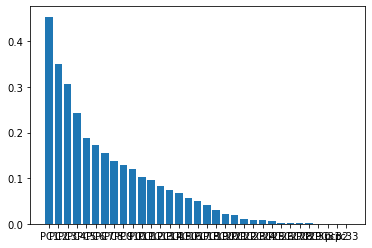

In [8]:
pca1 = PCA(n_components='mle')
train_x_norm = normalize(train_x,axis=0,norm='max')
train_x_1 = pca1.fit_transform(train_x_norm)
variance = pca1.explained_variance_
label = np.linspace(1,len(variance),len(variance))
label = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11','PC12','PC13','PC14','PC15','PC16','PC17','PC18','PC19','PC20','PC21','PC22','PC23','PC24','PC25','PC26','PC27','PC28','PC29','PC30','PC31','pc32','pc33']
plt.bar(label,variance)
plt.rcParams['figure.figsize'] = (18,10)
plt.show()

In [9]:
def pca(train_x,test_x,Using_PCA): 
    if not Using_PCA:
        return train_x,test_x
    pca1 = PCA(n_components='mle')
    train_x_norm = normalize(train_x,axis=0,norm='max')
    train_x_1 = pca1.fit_transform(train_x_norm)
    test_x_1 = pca1.transform(test_x)
    return train_x_1,test_x_1

# Decision tree--classification tree

In [10]:
def DecisionTree(train_x,train_y,test_x,criterion,max_depth):
    treeclf = DecisionTreeClassifier(criterion = criterion,max_depth = max_depth, random_state=1)
    treeclf.fit(train_x , train_y)# Fit model
    preds = treeclf.predict(test_x)# Predict
    return preds

Using PCA & Parameter Tuning

In [11]:
[train_x_pca,test_x_pca] = pca(train_x,test_x,Using_PCA = True)
params={
            'criterion':['gini','entropy'],
            'max_depth':[1,2,3,4,5,6,7,8,None]
            }
dtree=DecisionTreeClassifier(random_state=1)
cv = GridSearchCV(dtree, params, cv = 5, n_jobs = -1)
cv.fit(train_x_pca, train_y)
print(cv.best_params_)
criterion = cv.best_params_['criterion']
max_depth = cv.best_params_['max_depth']

{'criterion': 'entropy', 'max_depth': 3}


In [12]:
k_flod_id = np.int16(np.linspace(0,len(train_y),11))
acc_i = []
for i in range(0,10):
    test_x_i = train_x_pca[k_flod_id[i]:k_flod_id[i+1]]
    test_y_i = train_y[k_flod_id[i]:k_flod_id[i+1]]
    train_y_i = train_y[0:k_flod_id[i]].append(train_y[k_flod_id[i+1]:len(train_y)])
    train_x_i = np.vstack((train_x_pca[0:k_flod_id[i]],train_x_pca[k_flod_id[i+1]:len(train_y)]))
    preds_i = DecisionTree(train_x_i,train_y_i,test_x_i,criterion,max_depth)
    acc_i.append(sum(preds_i == test_y_i)/len(test_y_i))
np.average(acc_i)

0.689873949579832

Not Using PCA & Parameter Tuning

In [13]:
[train_x_pca,test_x_pca] = pca(train_x,test_x,Using_PCA = False)
params={
            'criterion':['gini','entropy'],
            'max_depth':[1,2,3,4,5,6,7,8,None]
            }
dtree=DecisionTreeClassifier(random_state=1)
cv = GridSearchCV(dtree, params, cv = 5, n_jobs = -1)
cv.fit(train_x_pca, train_y)
print(cv.best_params_)
criterion = cv.best_params_['criterion']
max_depth = cv.best_params_['max_depth']

{'criterion': 'gini', 'max_depth': 7}


K_Flod

In [14]:
k_flod_id = np.int16(np.linspace(0,len(train_y),11))
acc_i = []
for i in range(0,10):
    test_x_i = train_x_pca[k_flod_id[i]:k_flod_id[i+1]]
    test_y_i = train_y[k_flod_id[i]:k_flod_id[i+1]]
    train_y_i = train_y[0:k_flod_id[i]].append(train_y[k_flod_id[i+1]:len(train_y)])
    train_x_i = np.vstack((train_x_pca[0:k_flod_id[i]],train_x_pca[k_flod_id[i+1]:len(train_y)]))
    preds_i = DecisionTree(train_x_i,train_y_i,test_x_i,criterion,max_depth)
    acc_i.append(sum(preds_i == test_y_i)/len(test_y_i))
np.average(acc_i)

0.7440336134453782

# RandomForest--classification tree

In [15]:
[train_x_pca,test_x_pca] = pca(train_x,test_x,Using_PCA = False)
params={
    'n_estimators': [5, 50, 250],
    'max_depth': [2, 4, 8, 16, 32, None]
            }
rf = RandomForestClassifier(n_jobs = -1, random_state = 10)
cv = GridSearchCV(rf, params, cv = 5, n_jobs = -1)
cv.fit(train_x_pca, train_y)
print(cv.best_params_)
n_estimators = cv.best_params_['n_estimators']
max_depth = cv.best_params_['max_depth']

{'max_depth': 8, 'n_estimators': 250}


In [16]:
def RandomForest(train_x,train_y,test_x,n_estimators,max_depth):
    treeclf = RandomForestClassifier(n_estimators = n_estimators,max_depth = max_depth, random_state=1)
    treeclf.fit(train_x , train_y)# Fit model
    preds = treeclf.predict(test_x)# Predict
    return preds

In [17]:
k_flod_id = np.int16(np.linspace(0,len(train_y),11))
acc_i = []
for i in range(0,10):
    test_x_i = train_x_pca[k_flod_id[i]:k_flod_id[i+1]]
    test_y_i = train_y[k_flod_id[i]:k_flod_id[i+1]]
    train_y_i = train_y[0:k_flod_id[i]].append(train_y[k_flod_id[i+1]:len(train_y)])
    train_x_i = np.vstack((train_x_pca[0:k_flod_id[i]],train_x_pca[k_flod_id[i+1]:len(train_y)]))
    preds_i = RandomForest(train_x_i,train_y_i,test_x_i,n_estimators,max_depth)
    acc_i.append(sum(preds_i == test_y_i)/len(test_y_i))
np.average(acc_i)

0.7935994397759103

# GradientBoosting

In [18]:
[train_x_pca,test_x_pca] = pca(train_x,test_x,Using_PCA = False)
gbrt = GradientBoostingClassifier(random_state=0)
params={
    'subsample':[0.85,0.9,0.95],
    'n_estimators':[11,12,13,14,15,16,17],
    'learning_rate':[0.05,0.01, 0.005],
    'max_depth':[1,2,3,4,None]
}
cv = GridSearchCV(gbrt, params, cv = 5, n_jobs = -1)
cv.fit(train_x_pca, train_y)
print(cv.best_params_)
subsample = cv.best_params_['subsample']
n_estimators = cv.best_params_['n_estimators']
learning_rate = cv.best_params_['learning_rate']
max_depth = cv.best_params_['max_depth']

{'learning_rate': 0.05, 'max_depth': None, 'n_estimators': 17, 'subsample': 0.85}


In [19]:
def GradientBoosting(train_x,train_y,test_x,n_estimators,max_depth):
    treeclf = GradientBoostingClassifier(subsample = subsample,n_estimators = n_estimators, learning_rate = learning_rate,max_depth = max_depth, random_state=1)
    treeclf.fit(train_x , train_y)# Fit model
    preds = treeclf.predict(test_x)# Predict
    return preds

In [20]:
k_flod_id = np.int16(np.linspace(0,len(train_y),11))
acc_i = []
for i in range(0,10):
    test_x_i = train_x_pca[k_flod_id[i]:k_flod_id[i+1]]
    test_y_i = train_y[k_flod_id[i]:k_flod_id[i+1]]
    train_y_i = train_y[0:k_flod_id[i]].append(train_y[k_flod_id[i+1]:len(train_y)])
    train_x_i = np.vstack((train_x_pca[0:k_flod_id[i]],train_x_pca[k_flod_id[i+1]:len(train_y)]))
    preds_i = GradientBoosting(train_x_i,train_y_i,test_x_i,n_estimators,max_depth)
    acc_i.append(sum(preds_i == test_y_i)/len(test_y_i))
np.average(acc_i)

0.7676750700280112